In [42]:
import imghdr # builtin
from pathlib import Path
import sqlite3

import faiss
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
#from torchvision.datasets import ImageFolder
from torchvision.io import read_image
from transformers import CLIPProcessor, CLIPModel
from torchvision.transforms import ToTensor
from torchvision import transforms

# https://stackoverflow.com/questions/42462431/oserror-broken-data-stream-when-reading-image-file/47958486
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [17]:
# push the default CLIP transforms upstream to the data loader, 
# should permit batching iamges since we'll have a resize operation
# https://huggingface.co/transformers/model_doc/clip.html#transformers.CLIPFeatureExtractor
clip_transforms = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize(size=224),
    transforms.CenterCrop(224),
    #transforms.ToPILImage(),
    transforms.ToTensor(),  # PIL -> ToTensor :: [0,255] -> [0.,1.]
    transforms.Normalize([0.48145466, 0.4578275, 0.40821073], 
                         [0.26862954, 0.26130258, 0.27577711]),
    
])

In [58]:
class CLIP(torch.nn.Module):
    n_feats = 5125
    def __init__(self, model_string="openai/clip-vit-base-patch32"):
        super().__init__()
        self._model_string = model_string
        self.model = CLIPModel.from_pretrained(model_string)
        self.processor = CLIPProcessor.from_pretrained(model_string)
        self.model.eval()
    def project_images(self, images, normalize=True, preprocessed=False):
        if not preprocessed:
            imgs = self.processor(images=images, return_tensors="pt", padding=True)
        else:
            imgs = {'pixel_values':images}
        feats = self.model.get_image_features(**imgs)
        if normalize:
            feats = self.normalize(feats)
        return feats
    def project_texts(self, texts, normalize=True):
        txts = self.processor(text=texts, return_tensors="pt", padding=True)
        feats = self.model.get_text_features(**txts)
        if normalize:
            feats = self.normalize(feats)
        return feats
    def normalize(self, x):
        return x / x.norm(dim=-1, keepdim=True)

In [54]:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
# NB: might be able to use lightning datamodule to parallelize data processing
class RecusiveImagesPath(Dataset):
    def __init__(self, 
                 root='sample_data/images', 
                 transforms=clip_transforms,
                 #assign_ids=True, # doesn't need to be optional...
                 next_id=0
                ):
        if isinstance(root, str):
            root = Path(root)
        assert root.is_dir()
        self.root = root
        self.transforms = transforms
        #self.assign_ids = assign_ids
        self.next_id = next_id
        self.get_image_paths()
    def get_image_paths(self):
        self.img_paths = []
        for path_obj in self.root.glob('*'):
            if self._already_indexed(path_obj):
                continue
            if imghdr.what(path_obj) is not None:
                #self.img_paths.append(path_obj)
                self.img_paths.append((path_obj, self.next_id))
                self.next_id += 1
    def _already_indexed(self, path_obj):
        # implement this later, assume all images are new for now
        return False
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        #path = str(self.img_paths[idx])
        path_obj, im_id = self.img_paths[idx]
        path = str(path_obj)
        im = Image.open(path)
        if self.transforms is not None:
            im = self.transforms(im)
        #return im, path
        return im, path, im_id

In [59]:
clip = CLIP()

In [21]:
index_fname = 'sample_index.faissindex'
index=faiss.read_index(index_fname)

In [14]:
index.ntotal

8

In [61]:
images = [im for im,p in dataset]
im_embed = clip.project_images(images)
im_embed.shape, im_embed.requires_grad

(torch.Size([8, 512]), True)

In [35]:
texts = ["my baloney has a first name", "tropical beach", "beach", "sand beach with palm trees on a nice day"]
#txts = clip.processor(text=texts, return_tensors="pt", padding=True)
txt_embed = clip.project_texts(texts)
txt_embed.shape, txt_embed.norm(dim=-1)

(torch.Size([4, 512]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<CopyBackwards>))

In [62]:
sims = txt_embed @ im_embed.T
#torch.matmul(text_embeds, image_embeds.t()) * logit_scale
logit_scale = clip.model.logit_scale.exp()
sims, sims * logit_scale

(tensor([[0.1683, 0.1853, 0.1770, 0.1981, 0.2090, 0.1492, 0.1972, 0.1972],
         [0.2623, 0.2536, 0.1461, 0.1679, 0.1688, 0.1912, 0.1985, 0.1701],
         [0.2609, 0.2563, 0.1553, 0.1691, 0.1775, 0.1463, 0.1899, 0.1892],
         [0.2747, 0.2699, 0.1176, 0.1454, 0.1415, 0.1525, 0.1747, 0.1144]],
        grad_fn=<MmBackward>),
 tensor([[16.8332, 18.5312, 17.7043, 19.8129, 20.9047, 14.9190, 19.7199, 19.7210],
         [26.2350, 25.3636, 14.6130, 16.7930, 16.8836, 19.1164, 19.8490, 17.0067],
         [26.0949, 25.6321, 15.5259, 16.9058, 17.7491, 14.6251, 18.9940, 18.9170],
         [27.4703, 26.9878, 11.7571, 14.5414, 14.1530, 15.2501, 17.4696, 11.4387]],
        grad_fn=<MulBackward0>))

In [26]:
clip.model.logit_scale.exp() # uh.. ok

tensor(100.0000, grad_fn=<ExpBackward>)

In [63]:
#F.softmax(sims, dim=0)
im_embed.shape

torch.Size([8, 512])

In [70]:
im_embed.norm(dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<CopyBackwards>)

In [69]:
# https://github.com/facebookresearch/faiss/wiki/Getting-started
n_feats = 512 # = im_embed.shape
index = faiss.IndexFlatIP(n_feats)

In [71]:
x = im_embed.detach()
index.add(x.numpy())

In [66]:
index.is_trained, index.ntotal

(True, 8)

In [72]:
k = 3
x = txt_embed.detach().numpy()
D, I = index.search(x, k)
D,I

(array([[0.20904651, 0.19812861, 0.19721013],
        [0.26234967, 0.253636  , 0.1984902 ],
        [0.2609494 , 0.25632125, 0.1899397 ],
        [0.27470297, 0.26987785, 0.17469627]], dtype=float32),
 array([[4, 3, 7],
        [0, 1, 6],
        [0, 1, 6],
        [0, 1, 6]], dtype=int64))

In [73]:
faiss.write_index(index, 'sample_index.faissindex')

In [68]:
[
    "my baloney has a first name", 
    "tropical beach", 
    "beach", 
    "sand beach with palm trees on a nice day"]
for i, p in enumerate(dataset.img_paths):
    print(i,p)

0 sample_data\images\beach1.jpg
1 sample_data\images\beach2.jpg
2 sample_data\images\book1.jpg
3 sample_data\images\dog1.png
4 sample_data\images\dog2.png
5 sample_data\images\landscape1.jpg
6 sample_data\images\portrait1.jpg
7 sample_data\images\portrait2.jpg


In [55]:
%%time
# Let's try loading a bigger dataset
# This folder has about 5k images
fpath = r"C:\Users\shagg\Pictures\phone backup"
dataset = RecusiveImagesPath(root=fpath) 

Wall time: 424 ms


In [47]:
#%%time

import time
import numpy as np
#from loguru import logger

batch_sizes = 2**np.arange(5, 10)
elapsed = [] # Iteration only
elapsed_w_processing = []


def try_batch_size(b, max_samples=1024):
    n_feats = 512
    #index = faiss.IndexFlatIP(n_feats)
    img_loader = DataLoader(dataset, batch_size=int(b), shuffle=False)
    k = (max_samples / b) -1
    for i, (batch, paths, ids) in enumerate(img_loader):
        im_embed = clip.project_images(batch, normalize=True, preprocessed=True)
        #index.add(im_imbed)
        if i == k:
            break

experiments = []
n_tries = 5
with torch.no_grad():
    for b in batch_sizes:
        tries = []
        for _ in range(n_tries):
            st = time.time()
            ###############
            try_batch_size(b)
            #################
            et = time.time()        
            e = et - st
            print((b, e))
            experiments.append((b,e))
            #elapsed.append(e)
        #elapsed_w_processing.append(e)

(1, 87.55937790870667)
(1, 103.40788507461548)
(1, 111.80389714241028)
(1, 124.06582236289978)
(1, 118.63201856613159)
(2, 95.43580174446106)
(2, 99.1537573337555)
(2, 107.63567590713501)
(2, 115.75678420066833)
(2, 115.40816307067871)
(4, 109.15526986122131)
(4, 109.3173942565918)
(4, 108.98661804199219)
(4, 108.0500762462616)
(4, 108.37364888191223)
(8, 106.75039219856262)
(8, 108.72889018058777)
(8, 108.89992237091064)
(8, 108.77169871330261)
(8, 108.5592269897461)
(16, 106.71030879020691)
(16, 106.37933802604675)
(16, 106.47861409187317)
(16, 107.10803556442261)
(16, 107.1734721660614)
(32, 107.8037486076355)
(32, 105.18110370635986)
(32, 105.78199791908264)
(32, 104.88599348068237)
(32, 104.81387233734131)
(64, 104.15468192100525)
(64, 103.25387740135193)
(64, 103.43574666976929)
(64, 102.77426767349243)
(64, 101.6763014793396)
(128, 101.80644845962524)
(128, 101.79952454566956)
(128, 102.71944904327393)
(128, 101.44365501403809)
(128, 95.90809035301208)
(256, 87.34305500984192)
(

In [3]:
experiments = [
(1, 87.55937790870667),
(1, 103.40788507461548),
(1, 111.80389714241028),
(1, 124.06582236289978),
(1, 118.63201856613159),
(2, 95.43580174446106),
(2, 99.1537573337555),
(2, 107.63567590713501),
(2, 115.75678420066833),
(2, 115.40816307067871),
(4, 109.15526986122131),
(4, 109.3173942565918),
(4, 108.98661804199219),
(4, 108.0500762462616),
(4, 108.37364888191223),
(8, 106.75039219856262),
(8, 108.72889018058777),
(8, 108.89992237091064),
(8, 108.77169871330261),
(8, 108.5592269897461),
(16, 106.71030879020691),
(16, 106.37933802604675),
(16, 106.47861409187317),
(16, 107.10803556442261),
(16, 107.1734721660614),
(32, 107.8037486076355),
(32, 105.18110370635986),
(32, 105.78199791908264),
(32, 104.88599348068237),
(32, 104.81387233734131),
(64, 104.15468192100525),
(64, 103.25387740135193),
(64, 103.43574666976929),
(64, 102.77426767349243),
(64, 101.6763014793396),
(128, 101.80644845962524),
(128, 101.79952454566956),
(128, 102.71944904327393),
(128, 101.44365501403809),
(128, 95.90809035301208),
(256, 87.34305500984192),
(256, 88.98091220855713),
(256, 99.50674676895142),
(256, 96.46851015090942),
(256, 87.52513647079468),
(512, 96.5098397731781),
(512, 100.67550039291382),
(512, 88.8571720123291),
(512, 92.23456859588623),
(512, 101.21820855140686),
]

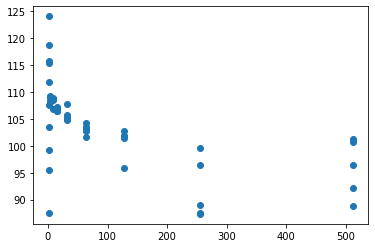

<AxesSubplot:xlabel='x', ylabel='y'>

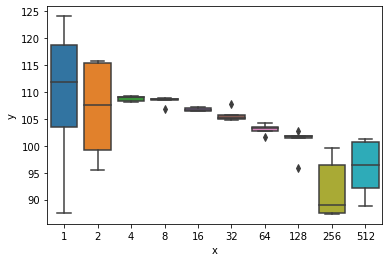

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

x,y = zip(*experiments)

plt.scatter(x,y)
plt.show()

sns.boxplot(x='x',y='y', data=pd.DataFrame({'x':x,'y':y}))

In [34]:
#%%time

import time
import numpy as np
from loguru import logger
import gc

batch_sizes = 2**np.arange(5, 10)
elapsed = [] # Iteration only
elapsed_w_processing = []


def try_batch_size(b, max_samples=1024):
    n_feats = 512
    index = faiss.IndexFlatIP(n_feats)
    img_loader = DataLoader(dataset, batch_size=int(b), shuffle=False)
    k = (max_samples / b) -1
    for i, (batch, paths, ids) in enumerate(img_loader):
        im_embed = clip.project_images(batch, normalize=True, preprocessed=True)
        index.add(im_embed.numpy())
        if i == k:
            break

experiments = []
n_tries = 1
with torch.no_grad():
    for b in batch_sizes:
        tries = []
        for _ in range(n_tries):
            gc.collect()
            st = time.time()
            ###############
            try_batch_size(b)
            #################
            et = time.time()        
            e = et - st
            print((b, e))
            experiments.append((b,e))
            #elapsed.append(e)
        #elapsed_w_processing.append(e)

(32, 181.6195933818817)
(64, 182.2417778968811)
(128, 178.59700441360474)
(256, 177.95661282539368)
(512, 189.41789293289185)


In [14]:
import tqdm

In [60]:
#from loguru import logger

#from tqdm import tqdm
from tqdm.notebook import tqdm

#index_fname = 'sample_index.faissindex'
#index=faiss.read_index(index_fname)
n_feats = 512
index = faiss.IndexFlatIP(n_feats)
index = faiss.IndexIDMap(index)

#b=128
b=16 # just so we dno't have to wait forever for first case to fail if it's gonna
img_loader = DataLoader(dataset, batch_size=int(b), shuffle=False)

with torch.no_grad():
    for i, (batch, paths, ids) in enumerate(tqdm(img_loader)):
        im_embed = clip.project_images(batch, normalize=True, preprocessed=True)
        #index.add(im_embed.numpy())
        vecs, ids = im_embed.numpy(), np.array(ids)
        index.add_with_ids(vecs, ids)

# 17min for 5k images, vectors w/o ids
        
st = time.time()
#faiss.write_index(index, 'test_5k.faissindex') # 0.0205
faiss.write_index(index, 'test_5k_w_ids.faissindex')
et = time.time()
print(et-st)


  0%|          | 0/337 [00:00<?, ?it/s]

0.010009527206420898


In [64]:
ids, index.ntotal

(array([5376, 5377, 5378, 5379], dtype=int64), 5380)

In [63]:
dir(index)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__swig_destroy__',
 '__weakref__',
 'add',
 'add_c',
 'add_with_ids',
 'add_with_ids_c',
 'assign',
 'assign_c',
 'compute_residual',
 'compute_residual_n',
 'd',
 'get_distance_computer',
 'id_map',
 'index',
 'is_trained',
 'metric_arg',
 'metric_type',
 'ntotal',
 'own_fields',
 'range_search',
 'range_search_c',
 'reconstruct',
 'reconstruct_c',
 'reconstruct_n',
 'reconstruct_n_c',
 'referenced_objects',
 'remove_ids',
 'remove_ids_c',
 'reset',
 'sa_code_size',
 'sa_decode',
 'sa_decode_c',
 'sa_encode',
 'sa_encode_c',
 'search',
 'search_and_reconstruct',
 'search_and_reconstruct_c',
 'search_c'

In [39]:
st = time.time()
faiss.write_index(index, 'test_5k.faissindex')
et = time.time()
print(et-st)
# no time at all!

0.020595788955688477


In [41]:
index.ntotal, index.is_trained # nice

(5380, True)

In [38]:
import gc
gc.collect()

139

In [126]:
%%time



# How long does it take to iterate through this? How does batch size impact this?
# What is the limit on batch size for a forward pass through the model?
# Can I calibrate this somehow? What about recording paths of images that we've processed already?

fpath = r"C:\Users\shagg\Pictures\phone backup"
dataset = RecusiveImagesPath(root=fpath)

#img_loader = DataLoader(dataset, batch_size=64, shuffle=False) # 9min 2s
#img_loader = DataLoader(dataset, batch_size=1, shuffle=False) # 12min43s w/o transforms
#img_loader = DataLoader(dataset, batch_size=2, shuffle=False)
#img_loader = DataLoader(dataset, batch_size=4, shuffle=False) # 8m w transforms (necessary for elevated batch size)
#img_loader = DataLoader(dataset, batch_size=8, shuffle=False) # 8min 28s
img_loader = DataLoader(dataset, batch_size=16, shuffle=False) # 8min 32s
# trying again with larger batch after adding transforms

for i, _ in enumerate(img_loader):
    continue
# yiiikes... 12min43s just to iterate through the files and load them into tensors... yeesh.
# seriously doubt I'm multiprocessing here. Possibly low batch size kills multiproc as option?


# TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; 
# found <class 'PIL.JpegImagePlugin.JpegImageFile'>
#
# fixed above error with torchvision.io.read_image
# Now we've got an uncollated shape issue
#   RuntimeError: stack expects each tensor to be equal size, but got [3, 3024, 4032] at entry 0 and [3, 2268, 4032] at entry 16
# could add a collate fn per: https://discuss.pytorch.org/t/dataloader-gives-stack-expects-each-tensor-to-be-equal-size-due-to-different-image-has-different-objects-number/91941
# ... but then the padding would probably fuck up the CLIP featurization
# could go the other way with a crop, but who even knows what I'd be cropping. How even does the model address the input resolution?
# whatever, let's see how long it takes with a batch_size of 1
#
# RuntimeError: Unsupported marker type 0xa3
# 'C:\\Users\\shagg\\Pictures\\phone backup\\20180913_145729.jpg' - panoramic, 35mb. 
#
# crushing error by returning tensor of zeros

Wall time: 8min 32s


In [ ]:
# let's see what happens if we turn up the num_workers
fpath = r"C:\Users\shagg\Pictures\phone backup"
dataset = RecusiveImagesPath(root=fpath)

#img_loader = DataLoader(dataset, batch_size=16, shuffle=False) # 8min 32s
#img_loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=4) # 
# yeeeaaah.... this slow af for some reason.
#for i, _ in enumerate(img_loader):
#    continue

In [127]:
help(DataLoader) # num_workers , prefetch_factor

Help on class DataLoader in module torch.utils.data.dataloader:

class DataLoader(typing.Generic)
 |  DataLoader(*args, **kwds)
 |  
 |  Data loader. Combines a dataset and a sampler, and provides an iterable over
 |  the given dataset.
 |  
 |  The :class:`~torch.utils.data.DataLoader` supports both map-style and
 |  iterable-style datasets with single- or multi-process loading, customizing
 |  loading order and optional automatic batching (collation) and memory pinning.
 |  
 |  See :py:mod:`torch.utils.data` documentation page for more details.
 |  
 |  Args:
 |      dataset (Dataset): dataset from which to load the data.
 |      batch_size (int, optional): how many samples per batch to load
 |          (default: ``1``).
 |      shuffle (bool, optional): set to ``True`` to have the data reshuffled
 |          at every epoch (default: ``False``).
 |      sampler (Sampler or Iterable, optional): defines the strategy to draw
 |          samples from the dataset. Can be any ``Iterable``

In [118]:
# OSError: broken data stream when reading image file
i, _[1] # the fuck? Why is path 4 files? oh right, batched

(46,
 ('C:\\Users\\shagg\\Pictures\\phone backup\\20180913_144244.jpg',
  'C:\\Users\\shagg\\Pictures\\phone backup\\20180913_144258.jpg',
  'C:\\Users\\shagg\\Pictures\\phone backup\\20180913_144303.jpg',
  'C:\\Users\\shagg\\Pictures\\phone backup\\20180913_144648.jpg'))

In [122]:
# OSError: broken data stream when reading image file
i, _[1] # 
# looks like the issue is with 'C:\\Users\\shagg\\Pictures\\phone backup\\20180913_145648.jpg' 

(94,
 ('C:\\Users\\shagg\\Pictures\\phone backup\\20180913_145647.jpg',
  'C:\\Users\\shagg\\Pictures\\phone backup\\20180913_145648.jpg'))

In [58]:
im_test = Image.open('C:\\Users\\shagg\\Pictures\\phone backup\\20180913_145729.jpg')
#im_test # PIL at least can read the last frame of the panorama.
ToTensor()(im_test)

tensor([[[0.5255, 0.5216, 0.5255,  ..., 0.1961, 0.2078, 0.1333],
         [0.5176, 0.5176, 0.5255,  ..., 0.2078, 0.1961, 0.1333],
         [0.5216, 0.5255, 0.5333,  ..., 0.1686, 0.1529, 0.1294],
         ...,
         [0.9804, 0.9765, 0.9765,  ..., 0.0275, 0.0392, 0.0392],
         [0.9765, 0.9765, 0.9765,  ..., 0.0235, 0.0353, 0.0314],
         [0.9765, 0.9725, 0.9765,  ..., 0.0157, 0.0314, 0.0353]],

        [[0.6196, 0.6157, 0.6118,  ..., 0.1569, 0.1686, 0.0941],
         [0.6118, 0.6118, 0.6118,  ..., 0.1686, 0.1569, 0.0941],
         [0.6078, 0.6118, 0.6196,  ..., 0.1294, 0.1137, 0.0902],
         ...,
         [0.9765, 0.9725, 0.9725,  ..., 0.0235, 0.0353, 0.0353],
         [0.9725, 0.9725, 0.9725,  ..., 0.0196, 0.0314, 0.0275],
         [0.9725, 0.9686, 0.9725,  ..., 0.0118, 0.0275, 0.0314]],

        [[0.7608, 0.7569, 0.7569,  ..., 0.1608, 0.1725, 0.0980],
         [0.7529, 0.7529, 0.7569,  ..., 0.1725, 0.1608, 0.0980],
         [0.7529, 0.7569, 0.7647,  ..., 0.1333, 0.1176, 0.

In [57]:
ToTensor()(im_test)

tensor([[[0.5255, 0.5216, 0.5255,  ..., 0.1961, 0.2078, 0.1333],
         [0.5176, 0.5176, 0.5255,  ..., 0.2078, 0.1961, 0.1333],
         [0.5216, 0.5255, 0.5333,  ..., 0.1686, 0.1529, 0.1294],
         ...,
         [0.9804, 0.9765, 0.9765,  ..., 0.0275, 0.0392, 0.0392],
         [0.9765, 0.9765, 0.9765,  ..., 0.0235, 0.0353, 0.0314],
         [0.9765, 0.9725, 0.9765,  ..., 0.0157, 0.0314, 0.0353]],

        [[0.6196, 0.6157, 0.6118,  ..., 0.1569, 0.1686, 0.0941],
         [0.6118, 0.6118, 0.6118,  ..., 0.1686, 0.1569, 0.0941],
         [0.6078, 0.6118, 0.6196,  ..., 0.1294, 0.1137, 0.0902],
         ...,
         [0.9765, 0.9725, 0.9725,  ..., 0.0235, 0.0353, 0.0353],
         [0.9725, 0.9725, 0.9725,  ..., 0.0196, 0.0314, 0.0275],
         [0.9725, 0.9686, 0.9725,  ..., 0.0118, 0.0275, 0.0314]],

        [[0.7608, 0.7569, 0.7569,  ..., 0.1608, 0.1725, 0.0980],
         [0.7529, 0.7529, 0.7569,  ..., 0.1725, 0.1608, 0.0980],
         [0.7529, 0.7569, 0.7647,  ..., 0.1333, 0.1176, 0.